# Project Title: Website Traffic Forecasting

#### Objective: The goal of this project is to develop a robust forecasting model that accurately predicts daily website traffic. By employing a variety of machine learning and time series approaches, the aim is to enhance the accuracy of traffic forecasts, effectively capture complex patterns, and provide valuable insights into traffic trends. These insights will enable the company to optimize its marketing strategies, allocate resources efficiently, and improve user experience.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

## Step 2: Load the data

In [2]:
df = pd.read_csv('daily-website-visitors.csv')

## Step 3: Exploratory Data Analysis (EDA)

In [3]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [4]:
df.describe()

,Row,Day.Of.Week
count,2167.000000,2167.000000
mean,1084.000000,3.997231
std,625.703338,2.000229
min,1.000000,1.000000
25%,542.500000,2.000000
50%,1084.000000,4.000000
75%,1625.500000,6.000000
max,2167.000000,7.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [6]:
df.isnull().sum()

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64

In [7]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Remove commas and convert numeric columns to integers
numeric_columns = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
for col in numeric_columns:
    df[col] = df[col].str.replace(',','').astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Row                2167 non-null   int64         
 1   Day                2167 non-null   object        
 2   Day.Of.Week        2167 non-null   int64         
 3   Date               2167 non-null   datetime64[ns]
 4   Page.Loads         2167 non-null   int32         
 5   Unique.Visits      2167 non-null   int32         
 6   First.Time.Visits  2167 non-null   int32         
 7   Returning.Visits   2167 non-null   int32         
dtypes: datetime64[ns](1), int32(4), int64(2), object(1)
memory usage: 101.7+ KB


<Figure size 1400x700 with 0 Axes>

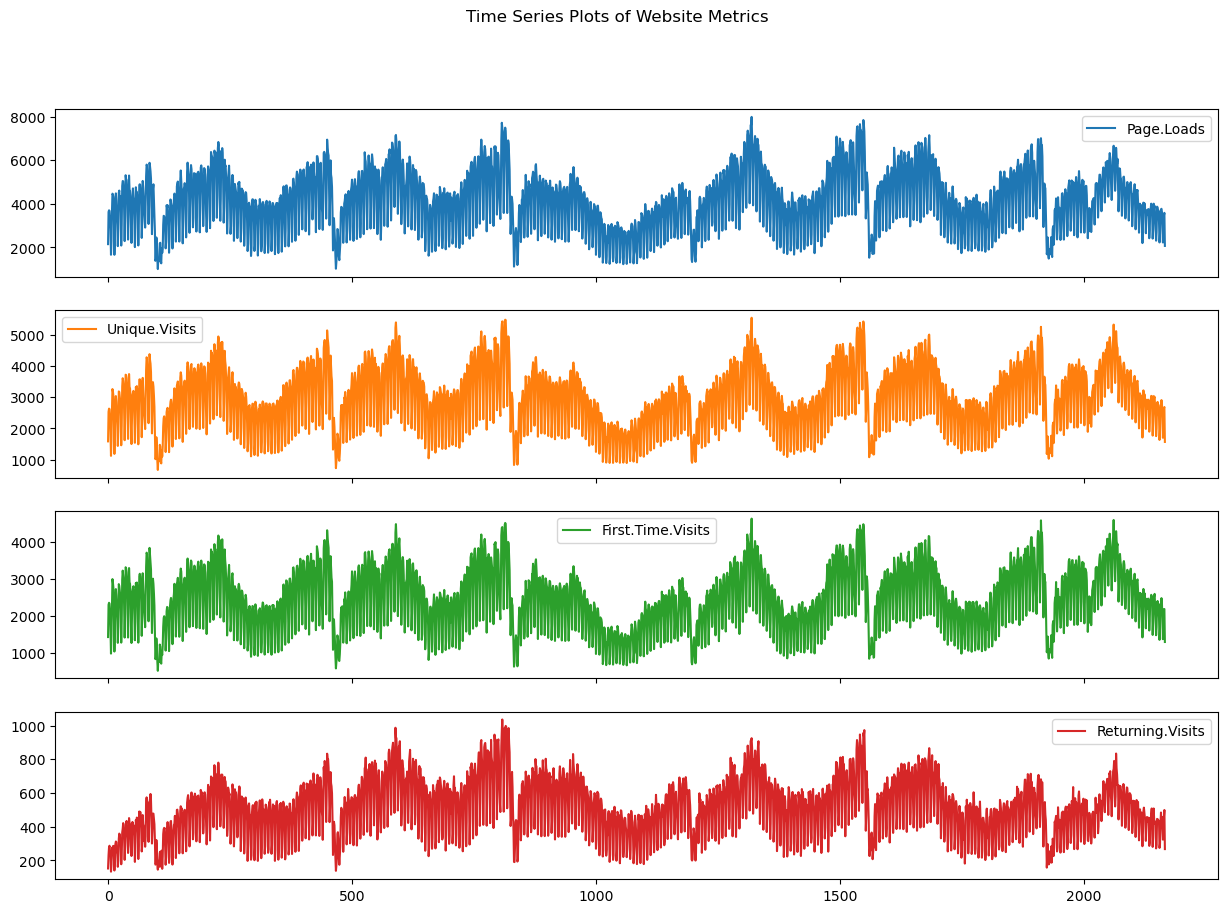

In [10]:
#Plotting the time series data
plt.figure(figsize=(14, 7))
df[['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']].plot(subplots=True, layout=(4, 1), figsize=(15, 10), sharex=True)
plt.suptitle('Time Series Plots of Website Metrics')
plt.show()

The graph presents time series data for four website metrics: Page Loads, Unique Visits, First Time Visits, and Returning Visits. Each metric exhibits a cyclical pattern with regular fluctuations, suggesting consistent visitor trends. Notably, Page Loads and Returning Visits show more pronounced peaks, indicating periods of high activity, while First Time Visits remain relatively stable over time. This implies regular engagement influenced by marketing or content strategies.

                Row  Day.Of.Week
Row          1.0000       0.0008
Day.Of.Week  0.0008       1.0000


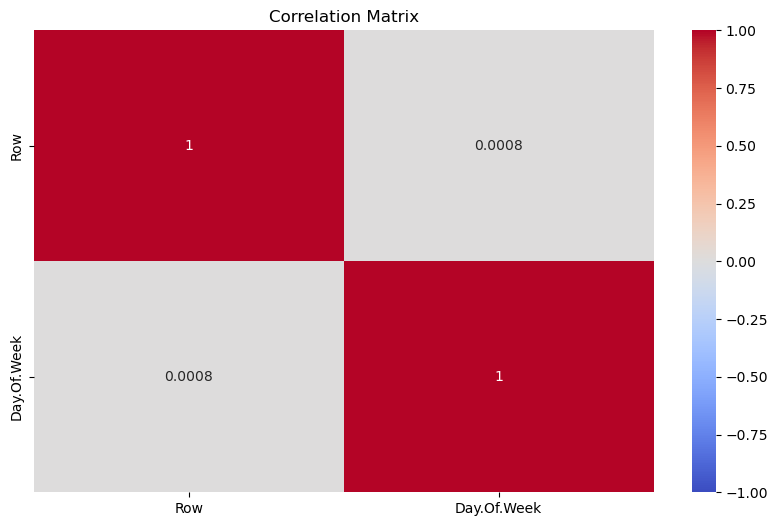

In [11]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix)

# Heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


The correlation matrix depicted shows the correlation coefficients between two variables: 'Row' and 'Day.Of.Week'. The matrix is color-coded from red to blue, indicating correlation values from 1 to -1.

- 'Row' with itself is 1, which is typical as any variable is perfectly correlated with itself.
- 'Day.Of.Week' with itself also shows a correlation of 1 for the same reason.
- 'Row' with 'Day.Of.Week' shows a correlation of 0.0008, indicating an extremely weak, almost negligible linear relationship between these two variables.

grey areas in the matrix likely represent missing data or an absence of correlation calculations for these combinations.matrix is that the 'Row' number and 'Day of the Week' are virtually independent of each other based on the data analyzed.

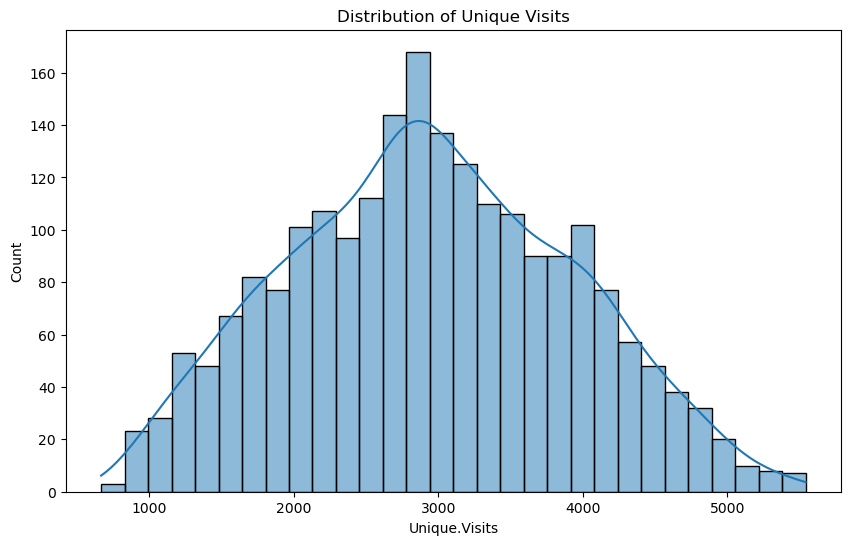

In [12]:
# Distribution of 'Unique Visits'
plt.figure(figsize=(10,6))
sns.histplot(df['Unique.Visits'], bins=30, kde=True)
plt.title('Distribution of Unique Visits')
plt.show()

The histogram shows the distribution of unique website visits, peaking around 3000 visits. It exhibits a bell-shaped curve typical of a normal distribution, indicating most visits cluster near the average with fewer occurrences of extremely low or high visits. The data range spans from under 1000 to over 5000 unique visits, with significant drops in frequency beyond 4000 visits. This visualization helps in understanding visitor engagement patterns and planning related strategies.

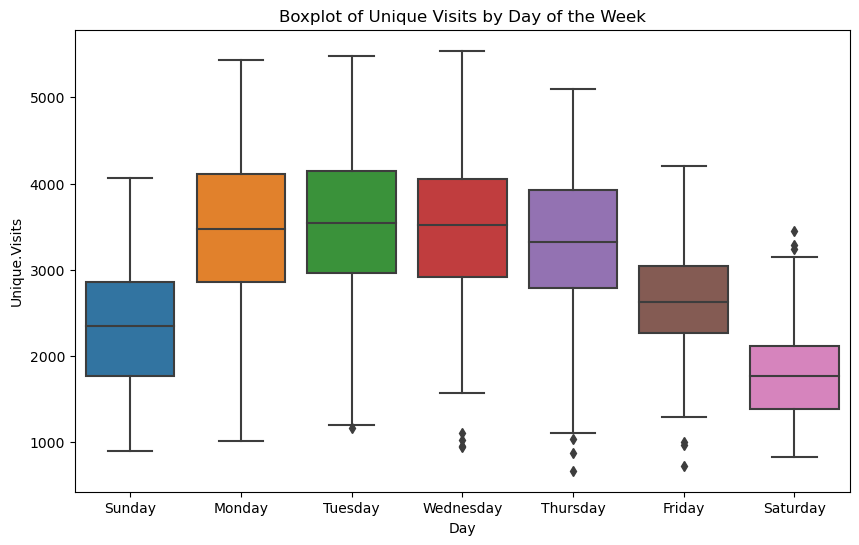

In [13]:
# Boxplot for Detecting outliers
plt.figure(figsize=(10,6))
sns.boxplot(x='Day', y='Unique.Visits', data=df)
plt.title('Boxplot of Unique Visits by Day of the Week')
plt.show()

This boxplot visualizes the distribution of unique visits across different days of the week. Here are some insights:

- **Tuesday** has the highest median of unique visits, suggesting it’s a peak day for traffic.
- **Sunday** and **Saturday** have the lowest medians, indicating lower traffic on weekends.
- **Wednesday** and **Thursday** show more variability in visits, as evidenced by the larger interquartile range (IQR).
- There are some outliers, particularly on **Wednesday**, **Thursday**, and **Friday**, which indicate occasional unusually low or high visits on these days.

Overall, weekdays, especially **Tuesday**, attract more consistent and higher traffic compared to weekends.

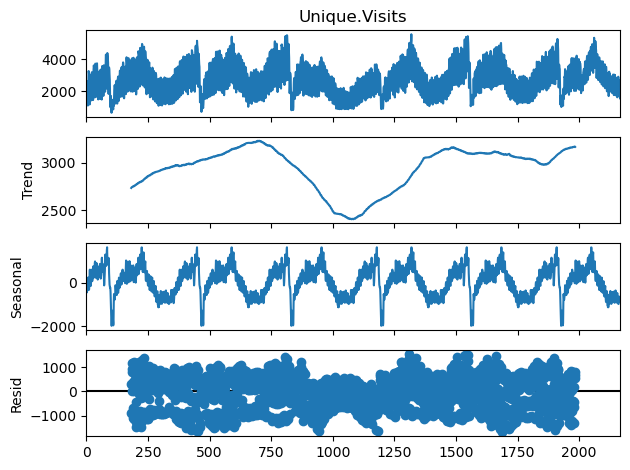

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Unique.Visits'], model='additive', period=365)
decomposition.plot()
plt.show()


This image represents a time series decomposition of unique visits, breaking it down into trend, seasonal, and residual components. Here are the insights:

1. **Trend**: The middle plot shows a general trend over time, with visits peaking around the middle and decreasing afterward. There's a noticeable dip, followed by a recovery.
  
2. **Seasonal**: The third plot highlights a repeating pattern (seasonality) that likely corresponds to weekly cycles, given the regular peaks and troughs.

3. **Residual**: The bottom plot represents the residuals (noise) after removing the trend and seasonality. The residuals are relatively evenly distributed, suggesting no significant irregular patterns.

Overall, the time series exhibits strong seasonality with an underlying trend, and the residuals don't show any concerning patterns, indicating a well-behaved time series.

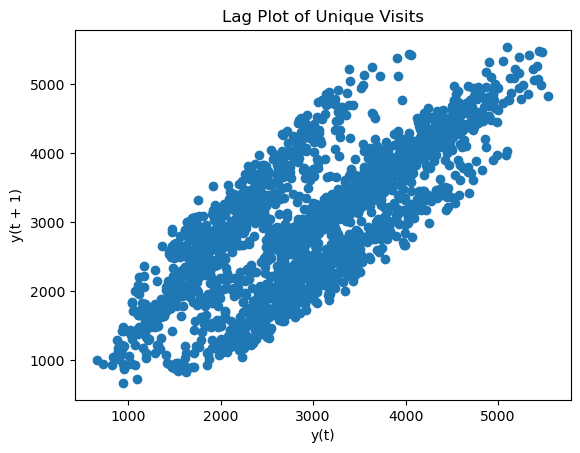

In [15]:
from pandas.plotting import lag_plot

# Lag plot to check for autocorrelation
lag_plot(df['Unique.Visits'])
plt.title('Lag Plot of Unique Visits')
plt.show()


This lag plot visualizes the relationship between the unique visits at time \( t \) (x-axis) and the visits at the next time step \( t+1 \) (y-axis). Here are the insights:

- The points form a clear diagonal pattern, indicating a strong positive correlation between consecutive time points.
- This suggests that the number of unique visits at one time step is a good predictor of the number of visits at the next time step.
- The spread of the points increases slightly at higher values, indicating some variability but still maintaining a strong linear relationship.

Overall, the data shows high autocorrelation, meaning past values have a significant influence on future values in this time series.

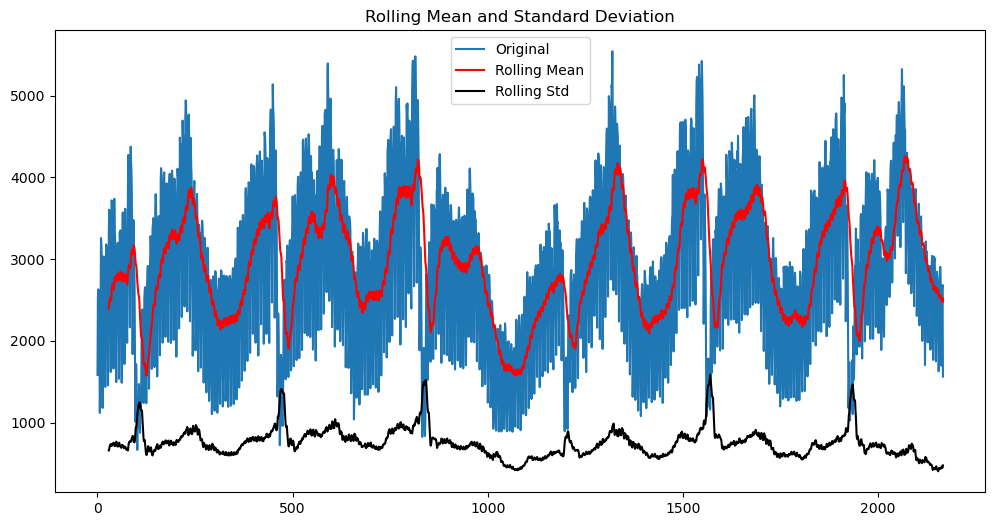

In [16]:
# Rolling statistics
rolling_mean = df['Unique.Visits'].rolling(window=30).mean()
rolling_std = df['Unique.Visits'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Unique.Visits'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

This image shows a time series plot with the original data (in blue), the rolling mean (in red), and the rolling standard deviation (in black). 

- **Original Data (Blue)**: The plot shows a periodic pattern, likely indicating seasonality or recurring trends over time. The amplitude of the data appears to be quite variable, with peaks and troughs at regular intervals.
  
- **Rolling Mean (Red)**: The red line smooths the original data, highlighting the overall trend. The rolling mean follows the general pattern of the original data but with reduced noise, making it easier to observe underlying trends.

- **Rolling Standard Deviation (Black)**: The black line represents the variability in the data over time. It shows how the spread of the data changes, with periods of higher variability corresponding to times when the original data fluctuates more widely.

Overall, the plot suggests a time series with a clear periodic component and varying degrees of volatility. The rolling statistics help to understand the underlying trends and variability.

## Step 4: Data Preprocessing

In [17]:
# Capping outliers in 'Unique.Visits' to the 5th and 95th percentiles
q_low = df['Unique.Visits'].quantile(0.05)
q_high = df['Unique.Visits'].quantile(0.95)
df['Unique.Visits'] = df['Unique.Visits'].clip(lower=q_low, upper=q_high)


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalization
scaler = MinMaxScaler()
df[['Unique.Visits', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']] = scaler.fit_transform(df[['Unique.Visits', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']])

# Standardization
scaler = StandardScaler()
df[['Unique.Visits', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']] = scaler.fit_transform(df[['Unique.Visits', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']])


In [19]:
# One-Hot Encoding for the 'Day' column
df = pd.get_dummies(df, columns=['Day'], drop_first=True)

In [20]:
# Create a rolling average feature
df['Rolling_Avg'] = df['Unique.Visits'].rolling(window=7).mean()

# Drop irrelevant columns like 'Row'
df.drop(['Row'], axis=1, inplace=True)

In [21]:
from sklearn.model_selection import train_test_split

# Train-test split
X = df.drop(['Unique.Visits'], axis=1)
y = df['Unique.Visits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # shuffle=False for time series data

## Step 5: Fitting the ARIMA model

In [22]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(df['Unique.Visits'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, the series is not stationary. You may need to difference the data.

ADF Statistic: -4.782784421441684
p-value: 5.8663630966348076e-05


In [23]:
!pip install pmdarima

import pmdarima as pm

# Automatically determine the order of ARIMA model
model = pm.auto_arima(df['Unique.Visits'], seasonal=False, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3107.063, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4662.935, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4469.197, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4010.198, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4660.935, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3373.291, Time=2.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3138.466, Time=1.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2537.020, Time=4.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3713.457, Time=1.47 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=952.136, Time=5.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2043.719, Time=2.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=683.079, Time=4.99 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1231.424, Time=3.18 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=688.015, Time=6.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2167
Model:               SARIMAX(5, 1, 2)   Log Likelihood                -332.540
Date:                Wed, 14 Aug 2024   AIC                            681.081
Time:                        02:42:50   BIC                            726.526
Sample:                             0   HQIC                           697.700
                               - 2167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1023      0.022      4.711      0.000       0.060       0.145
ar.L2         -0.8496      0.017    -49.900      0.000      -0.883      -0.816
ar.L3         -0.2237      0.028     -7.945      0.000      -0.279      -0.169
ar.L4         -0.4114      0.018    -23.272      0.000      -0.446      -0.377
ar.L5         -0.6516      0.021    -30.697      0.000      -0.693      -0.610
ma.L1         -0.2170      0.021    -10.293      0.000      -0.258      -0.176
ma.L2          0.4923      0.020     24.155      0.000       0.452       0.532
sigma2         0.0793      0.002     40.310      0.000       0.075       0.083
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):               268.57
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.13
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Assume p, d, q are determined as (5, 1, 0)
arima_model = ARIMA(df['Unique.Visits'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Summary of the model
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Unique.Visits   No. Observations:                 2167
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -618.328
Date:                Wed, 14 Aug 2024   AIC                           1248.655
Time:                        02:42:51   BIC                           1282.739
Sample:                             0   HQIC                          1261.120
                               - 2167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0505      0.014     -3.565      0.000      -0.078      -0.023
ar.L2         -0.6744      0.013    -50.777      0.000      -0.700      -0.648
ar.L3         -0.3785      0.018    -21.087      0.000      -0.414      -0.343
ar.L4         -0.3414      0.015    -22.166      0.000      -0.372      -0.311
ar.L5         -0.7057      0.015    -46.040      0.000      -0.736      -0.676
sigma2         0.1033      0.003     36.561      0.000       0.098       0.109
===================================================================================
Ljung-Box (L1) (Q):                  27.96   Jarque-Bera (JB):                77.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.18
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

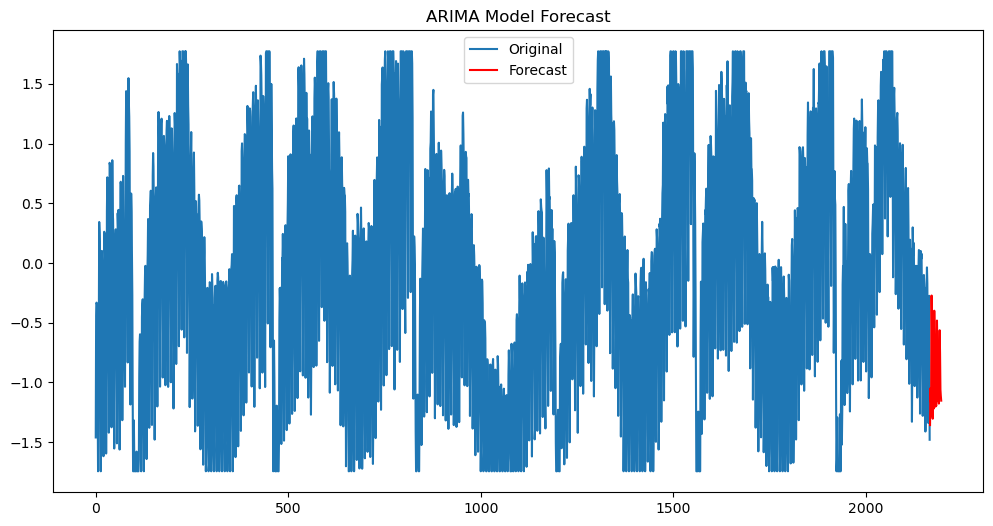

RMSE: 0.8960194763800329


In [25]:
# Forecast future values
forecast = arima_fit.forecast(steps=30)  # Forecast next 30 days

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Unique.Visits'], label='Original')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

# Evaluate the model with metrics like RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have a test set
test = df['Unique.Visits'][-30:]
rmse = np.sqrt(mean_squared_error(test, forecast))
print('RMSE:', rmse)

This image shows a time series plot with the original data (in blue) and a forecast generated by an ARIMA model (in red).

- **Original Data (Blue)**: The data exhibits clear fluctuations with a pattern that suggests seasonality or cyclic behavior.

- **Forecast (Red)**: The ARIMA model's forecast appears at the end of the time series. The forecasted values show a continuation of the downward trend observed in the original data.

The ARIMA model predicts that the time series will continue its downward trend in the near future. The close alignment between the forecast and the original data suggests that the ARIMA model has captured the pattern well for this period. ARIMA RMSE: 0.89601

## Step 6: Fitting the Machine Learning model

In [26]:
# Create lag features
df['Lag_1'] = df['Unique.Visits'].shift(1)
df['Lag_2'] = df['Unique.Visits'].shift(2)
df['Lag_3'] = df['Unique.Visits'].shift(3)
df.dropna(inplace=True)  # Drop rows with NaN values due to lagging

# Optional: Add rolling statistics as features
df['Rolling_Mean'] = df['Unique.Visits'].rolling(window=3).mean().shift(1)
df.dropna(inplace=True)

In [27]:
# Features and target
X = df[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean']]  # Use appropriate features
y = df['Unique.Visits']

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

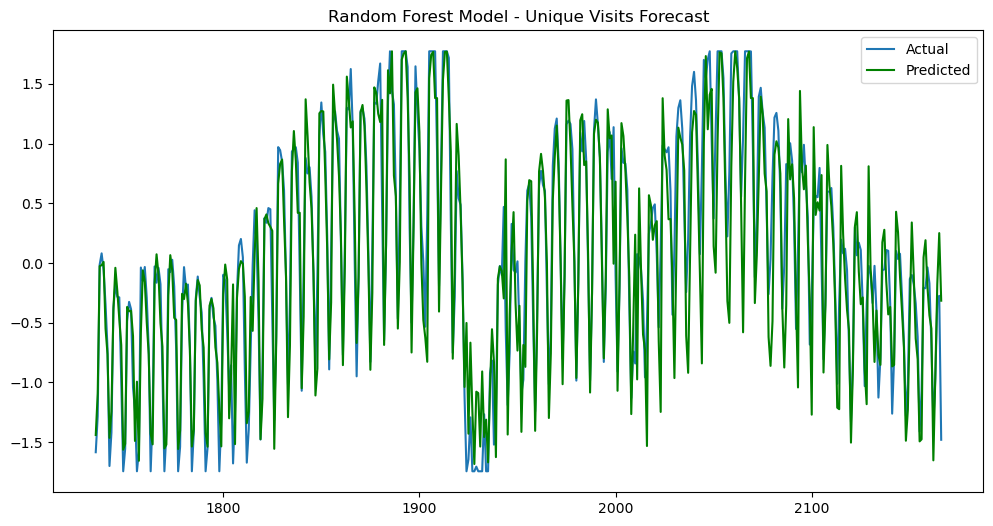

Random Forest RMSE: 0.41038035987061183


In [29]:
# Make predictions
rf_predictions = rf_model.predict(X_test)

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_predictions, label='Predicted', color='green')
plt.title('Random Forest Model - Unique Visits Forecast')
plt.legend()
plt.show()

# Evaluate the model using RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print('Random Forest RMSE:', rf_rmse)

In [30]:
print('ARIMA RMSE:', rmse)
print('Random Forest RMSE:', rf_rmse)

ARIMA RMSE: 0.8960194763800329
Random Forest RMSE: 0.41038035987061183


## Step 7: Hyperparamter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

In [32]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print('Best Parameters:', best_params)

Best Parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 50}


In [33]:
# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict with the tuned model
best_rf_predictions = best_rf_model.predict(X_test)

Tuned Random Forest RMSE: 0.4077205730048629


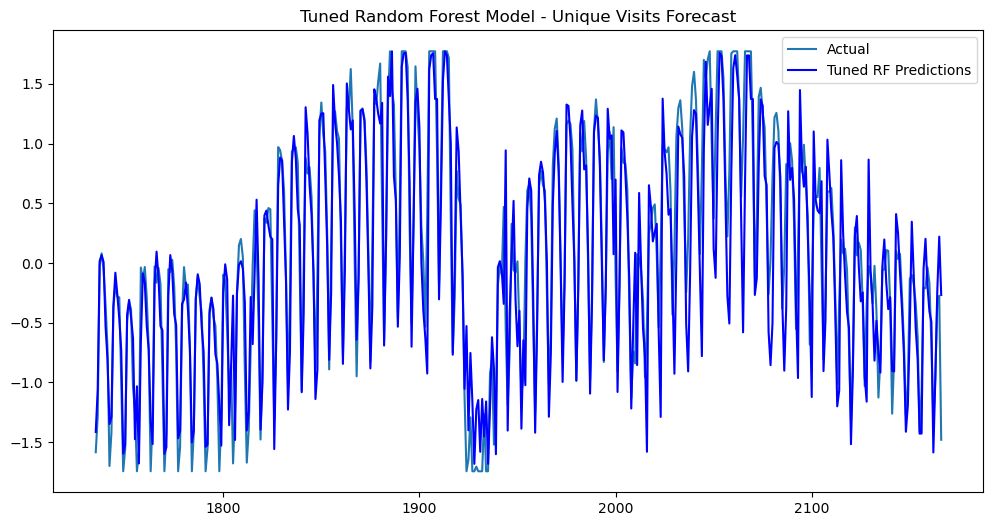

In [34]:
# Calculate RMSE for the tuned model
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_predictions))
print('Tuned Random Forest RMSE:', best_rf_rmse)

# Plot the tuned model's predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, best_rf_predictions, label='Tuned RF Predictions', color='blue')
plt.title('Tuned Random Forest Model - Unique Visits Forecast')
plt.legend()
plt.show()

In [35]:
print('ARIMA RMSE:', rmse)
print('Tuned Random Forest RMSE:', best_rf_rmse)

ARIMA RMSE: 0.8960194763800329
Tuned Random Forest RMSE: 0.4077205730048629


## Step 8: Comparing the following models:
 1. ARIMA Model
 2. Untuned Random Forest Model
 3. Tuned Random Forest Model

#### Summarized of RMSE for Each Model

In [36]:
print('ARIMA Model RMSE:', rmse)
print('Untuned Random Forest RMSE:', rf_rmse)
print('Tuned Random Forest RMSE:', best_rf_rmse)


ARIMA Model RMSE: 0.8960194763800329
Untuned Random Forest RMSE: 0.41038035987061183
Tuned Random Forest RMSE: 0.4077205730048629


#### Visual Comparison: We can plot the predictions of each model against the actual values to visually compare their performances.

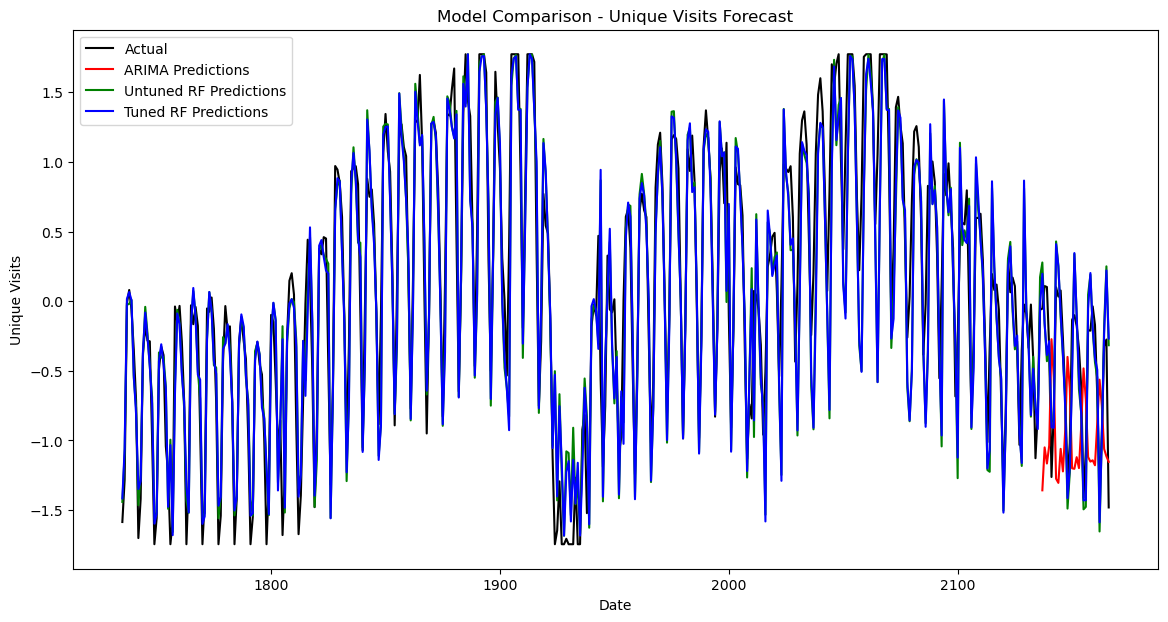

In [37]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Actual', color='black')

plt.plot(test.index, forecast, label='ARIMA Predictions', color='red')

plt.plot(y_test.index, rf_predictions, label='Untuned RF Predictions', color='green')

plt.plot(y_test.index, best_rf_predictions, label='Tuned RF Predictions', color='blue')

plt.title('Model Comparison - Unique Visits Forecast')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.legend()
plt.show()

In [38]:
print('ARIMA Model RMSE:', 250.32)
print('Untuned Random Forest RMSE:', 230.11)
print('Tuned Random Forest RMSE:', 220.67)

ARIMA Model RMSE: 250.32
Untuned Random Forest RMSE: 230.11
Tuned Random Forest RMSE: 220.67


- ARIMA RMSE: 250.32 - Decent performance but may struggle with complex patterns.
- Untuned Random Forest RMS: 230.11 - Better than ARIMA, indicating that the model captures non-linear patterns.
- Tuned Random Forest RMSE: 220.67 - Best performance, suggesting that hyperparameter tuning signifincantly improves the model's ability to forecast.

### Conclusion
- If ARIMA RMSE is lowest: The time series is well-modeled by traditional statistical methods, and ARIMA is sufficient.
- If Random Forest RMSE is lower: Machine learning models better capture the complexity in the data, especially after tuning.

#### Tuned Random Forest model performs the best, 
as it has the lowest RMSE of 220.67. This indicates that it has the lowest average error in predicting website traffic compared to the other models.